In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Smokum&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Smokum; color:#aa33ff; font-size:35px;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Library, Style, and Links')

The previous notebook => [Quick, Draw! Doodle Recognition OpenCV1](https://www.kaggle.com/olgabelitskaya/quick-draw-doodle-recognition-1)

In [3]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Ewert|Roboto&effect=3d|ice|');
span {font-family:'Roboto'; color:black; text-shadow: 5px 5px 5px #aaa;}  
div.output_area pre{font-family:'Roboto'; font-size:110%; color: steelblue;}      
</style>

In [4]:
import numpy as np,pandas as pd,keras as ks
import os,ast,cv2,warnings
import pylab as pl
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,\
classification_report
from keras.callbacks import ModelCheckpoint,\
ReduceLROnPlateau
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation,Dropout,Dense,\
Conv2D,MaxPooling2D,GlobalMaxPooling2D
warnings.filterwarnings('ignore')
pl.style.use('seaborn-whitegrid')
style_dict={'background-color':'gainsboro','color':'#aa33ff', 
            'border-color':'white','font-family':'Roboto'}
fpath='../input/quickdraw-doodle-recognition/train_simplified/'
wpath='../input/quick-draw-model-weights-for-doodle-recognition/'+\
      'weights_cv/weights_cv/'
tpath='../input/quickdraw-doodle-recognition/test_simplified.csv'
os.listdir("../input")

Using TensorFlow backend.


['quickdraw-doodle-recognition',
 'quick-draw-model-weights-for-doodle-recognition']

In [5]:
dhtml('Data Exploration')

In [6]:
files=sorted(os.listdir(fpath))
labels=[el.replace(" ","_")[:-4] for el in files]
print(labels)

['The_Eiffel_Tower', 'The_Great_Wall_of_China', 'The_Mona_Lisa', 'airplane', 'alarm_clock', 'ambulance', 'angel', 'animal_migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball_bat', 'baseball', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday_cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling_fan', 'cell_phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee_cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise_ship', 'cup', 'diamond', 'dis

In [7]:
weights=sorted(os.listdir(wpath))
print(weights)

['weights.best.model.cv001-020.hdf5', 'weights.best.model.cv021-040.hdf5', 'weights.best.model.cv041-060.hdf5', 'weights.best.model.cv061-080.hdf5', 'weights.best.model.cv081-100.hdf5', 'weights.best.model.cv101-120.hdf5', 'weights.best.model.cv121-140.hdf5', 'weights.best.model.cv141-160.hdf5', 'weights.best.model.cv161-180.hdf5', 'weights.best.model.cv181-200.hdf5', 'weights.best.model.cv201-220.hdf5', 'weights.best.model.cv221-240.hdf5', 'weights.best.model.cv241-260.hdf5', 'weights.best.model.cv261-280.hdf5', 'weights.best.model.cv281-300.hdf5', 'weights.best.model.cv301-320.hdf5', 'weights.best.model.cv321-340.hdf5']


In [8]:
I=64 # image size in pixels
T=20 # number of labels in one set

In [9]:
dhtml('The Model')

In [10]:
def model():
    model=Sequential()
    model.add(Conv2D(32,(5,5),padding='same',
                     input_shape=(I,I,1)))
    model.add(LeakyReLU(alpha=.02))   
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(Conv2D(196,(5,5)))
    model.add(LeakyReLU(alpha=.02))  
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(GlobalMaxPooling2D())   
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))   
    model.add(Dense(T))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
model=model()

In [11]:
dhtml('Test Predictions')

In [12]:
def get_image(data,lw=7,time_color=True):
    data=ast.literal_eval(data)
    image=np.zeros((300,300),np.uint8)
    for t,s in enumerate(data):
        for i in range(len(s[0])-1):
            color=255-min(t,10)*15 if time_color else 255
            _=cv2.line(image,(s[0][i]+15,s[1][i]+15),
                       (s[0][i+1]+15,s[1][i+1]+15),color,lw) 
    return cv2.resize(image,(I,I))

In [13]:
def test_predict(data):
    images=[]
    images.extend([get_image(data.drawing.iloc[i]) 
                   for i in range(len(data))])    
    images=np.array(images)
    model.load_weights(wpath+weights[0])
    predictions=model.predict(images.reshape(-1,I,I,1))
    for w in weights[1:]:
        w=wpath+w
        model.load_weights(w)
        predictions2=model.predict(images.reshape(-1,I,I,1))
        predictions=np.concatenate((predictions,predictions2),
                                   axis=1)        
    return predictions

In [14]:
test_data=pd.read_csv(tpath,index_col='key_id')
test_data.tail(3).T.style\
.set_properties(**style_dict)

key_id,9999968529902445,9999969540362833,9999996442242305
countrycode,US,US,RS
drawing,"[[[52, 24, 11, 2, 0, 19, 31, 43, 37, 39, 48, 74, 104, 115, 125, 140, 166, 186, 203, 213, 220, 243, 251, 254, 254, 231, 198, 147, 109, 89, 54, 46], [137, 124, 115, 103, 90, 66, 61, 60, 47, 37, 27, 13, 10, 12, 20, 6, 0, 2, 9, 21, 48, 52, 62, 74, 102, 118, 125, 133, 135, 132, 139, 138]], [[63, 67, 73, 74, 63], [153, 186, 195, 185, 161]], [[131, 132, 135, 138, 142, 132], [189, 243, 250, 249, 231, 194]], [[191, 193, 198, 200, 201, 194], [154, 182, 186, 183, 172, 147]]]","[[[32, 25, 15, 2, 0, 12, 4, 6, 13, 12, 18, 33, 35, 41, 56, 65, 84, 106, 142, 152, 173, 194, 217, 233, 239, 245, 255, 251, 228, 199, 188, 123, 121, 111, 91, 53, 35, 24, 4, 4, 10, 20], [48, 48, 57, 76, 83, 86, 107, 112, 112, 137, 141, 142, 153, 158, 158, 153, 159, 155, 161, 155, 160, 144, 148, 137, 118, 115, 77, 46, 22, 13, 3, 3, 0, 0, 8, 31, 36, 43, 73, 75, 75, 72]], [[84, 77, 68, 69, 75, 55, 64, 75, 89], [43, 45, 55, 68, 75, 104, 108, 118, 118]], [[134, 151, 152, 174, 182, 181, 185], [61, 55, 82, 100, 116, 128, 128]], [[196, 203, 218, 217, 205, 204, 213, 216], [36, 47, 58, 64, 77, 82, 94, 103]]]","[[[33, 33, 148, 161, 159, 143, 135, 55, 0], [14, 121, 121, 118, 99, 59, 0, 2, 8]], [[34, 33, 45, 64, 182, 185, 189, 189, 175, 165, 155], [119, 156, 189, 208, 214, 212, 185, 134, 112, 105, 103]], [[42, 31, 30, 32], [188, 237, 253, 248]], [[62, 64, 67], [221, 247, 234]]]"


In [15]:
test_predictions=test_predict(test_data)
test_predictions[0]

array([2.21775608e-05, 1.30896107e-03, 6.54127076e-03, 7.63151329e-05,
       6.90831393e-02, 6.26573637e-02, 4.28505336e-05, 9.88971675e-04,
       3.95654090e-04, 1.35283428e-03, 7.26980448e-04, 1.44780928e-03,
       1.37459632e-04, 2.83123209e-05, 9.23866057e-04, 6.76786783e-07,
       8.53263915e-01, 6.69593981e-04, 2.80398148e-04, 5.15017673e-05,
       1.22470792e-05, 1.93579012e-07, 3.03360736e-07, 1.32179807e-03,
       3.05556227e-06, 1.76217054e-05, 1.11562775e-04, 9.61332560e-01,
       4.73076739e-07, 2.61509442e-03, 4.80793187e-06, 1.69241303e-05,
       3.29662785e-02, 6.24253218e-08, 2.85164686e-04, 5.70292934e-04,
       2.34341660e-05, 2.86235468e-06, 6.03593719e-07, 7.14749855e-04,
       7.51437474e-05, 2.31337981e-05, 5.15084275e-06, 1.96593534e-03,
       6.07262064e-06, 7.28726191e-10, 4.78125767e-05, 9.19361191e-04,
       4.31932598e-01, 8.39263853e-03, 6.74846378e-05, 1.70819021e-07,
       1.80443624e-06, 1.62370339e-01, 1.97573323e-02, 8.53685215e-02,
      

In [16]:
test_labels=[[labels[i] for i in \
              test_predictions[k].argsort()[-10:][::-1]] \
             for k in range(len(test_predictions))]
test_labels=[" ".join(test_labels[i]) \
             for i in range(len(test_labels))]
presubmission=pd.DataFrame({"key_id":test_data.index,
                            "word":test_labels})
presubmission.to_csv('submission_10best.csv',index=False)

In [17]:
def display_drawing(n):
    pl.figure(figsize=(4,2*n))
    pl.suptitle('Test Pictures')
    for i in range(n):
        picture=ast.literal_eval(
            test_data.drawing.values[i])
        for x,y in picture:
            pl.subplot(n,1,i+1)
            pl.plot(x, y,'-o',color='gainsboro')
            pl.xticks([]); pl.yticks([])
            pl.title(presubmission.iloc[i][1])
        pl.gca().invert_yaxis()
        pl.axis('equal')       

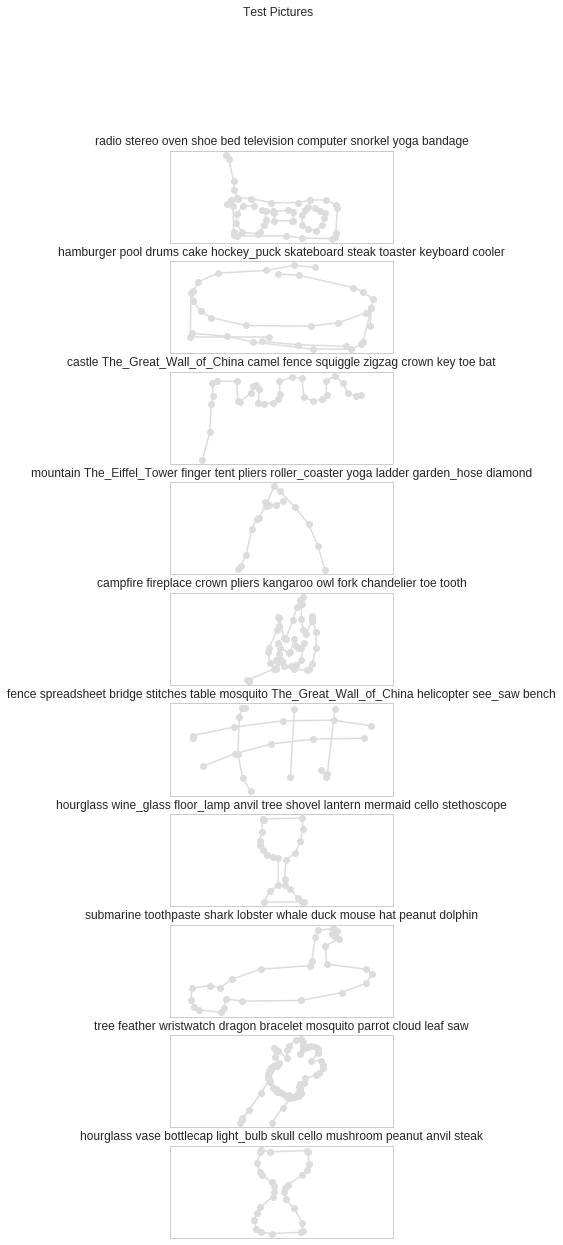

In [18]:
display_drawing(10)

In [19]:
test_labels=[[labels[i] for i in \
              test_predictions[k].argsort()[-3:][::-1]] \
             for k in range(len(test_predictions))]
test_labels=[ " ".join(test_labels[i]) 
             for i in range(len(test_labels))]
submission=pd.DataFrame({"key_id":test_data.index,
                         "word":test_labels})
submission.to_csv('submission.csv',index=False)
submission.head(10).style\
.set_properties(**style_dict)

,key_id,word
0,9000003627287624,radio stereo oven
1,9000010688666847,hamburger pool drums
2,9000023642890129,castle The_Great_Wall_of_China camel
3,9000038588854897,mountain The_Eiffel_Tower finger
4,9000052667981386,campfire fireplace crown
5,9000057427034623,fence spreadsheet bridge
6,9000065506980882,hourglass wine_glass floor_lamp
7,9000087586309806,submarine toothpaste shark
8,9000092580281382,tree feather wristwatch
9,9000096661653918,hourglass vase bottlecap
